# Context extraction model

## Training the model

In [1]:
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np

import evaluate

In [2]:
label_all_tokens = True

In [3]:
# Load the dataset
dataset = load_dataset('conll2012_ontonotesv5', 'english_v12', split='train')

In [24]:
# Define label mappings
labels_list = dataset.features['sentences'][0]['named_entities'].feature.names
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for i, label in enumerate(labels_list)}

In [25]:
# Initialize the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [26]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = {
        'input_ids': [],
        'attention_mask': [],
        'labels': []
    }
    
    for sentences in examples['sentences']:
        for sentence in sentences:
            words = sentence['words']
            labels = sentence['named_entities']
            
            tokenized_input = tokenizer(words, truncation=True, is_split_into_words=True)
            
            aligned_labels = []
            word_ids = tokenized_input.word_ids()
            previous_word_idx = None
            for word_idx in word_ids:
                if word_idx is None:
                    aligned_labels.append(-100)
                elif word_idx != previous_word_idx:
                    aligned_labels.append(labels[word_idx])
                else:
                    aligned_labels.append(labels[word_idx] if label_all_tokens else -100)
                previous_word_idx = word_idx
            
            tokenized_input["labels"] = aligned_labels
            
            tokenized_inputs['input_ids'].append(tokenized_input['input_ids'])
            tokenized_inputs['attention_mask'].append(tokenized_input['attention_mask'])
            tokenized_inputs['labels'].append(tokenized_input['labels'])

    return tokenized_inputs

In [27]:
# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset.column_names)

In [28]:
# Load the pre-trained BERT model for token classification
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label2id))
model.config.id2label = id2label
model.config.label2id = label2id

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Define the data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

In [30]:
# Define the evaluation metric
metric = evaluate.load("seqeval")

In [31]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [model.config.id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [model.config.id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [32]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
# Split the tokenized dataset into train and validation sets
train_test_split = tokenized_datasets.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

In [34]:
# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [35]:
# Train the model
trainer.train()

  0%|          | 0/19545 [00:00<?, ?it/s]

c:\Users\Jerome\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 0.3409, 'grad_norm': 2.246727466583252, 'learning_rate': 1.9488360194423127e-05, 'epoch': 0.08}
{'loss': 0.1362, 'grad_norm': 1.173071026802063, 'learning_rate': 1.8976720388846255e-05, 'epoch': 0.15}
{'loss': 0.117, 'grad_norm': 2.0051515102386475, 'learning_rate': 1.846508058326938e-05, 'epoch': 0.23}
{'loss': 0.1091, 'grad_norm': 0.8002653121948242, 'learning_rate': 1.7953440777692505e-05, 'epoch': 0.31}
{'loss': 0.1003, 'grad_norm': 1.4730002880096436, 'learning_rate': 1.7441800972115634e-05, 'epoch': 0.38}
{'loss': 0.0969, 'grad_norm': 0.8232213854789734, 'learning_rate': 1.693016116653876e-05, 'epoch': 0.46}
{'loss': 0.0983, 'grad_norm': 0.641442596912384, 'learning_rate': 1.6418521360961884e-05, 'epoch': 0.54}
{'loss': 0.0893, 'grad_norm': 3.6875345706939697, 'learning_rate': 1.590688155538501e-05, 'epoch': 0.61}
{'loss': 0.0904, 'grad_norm': 1.157231092453003, 'learning_rate': 1.5395241749808137e-05, 'epoch': 0.69}
{'loss': 0.0831, 'grad_norm': 0.9579925537109375, 'lea

  0%|          | 0/724 [00:00<?, ?it/s]

{'eval_loss': 0.07870307564735413, 'eval_precision': 0.8533802964987909, 'eval_recall': 0.8871461361897475, 'eval_f1': 0.869935691318328, 'eval_accuracy': 0.976854976378578, 'eval_runtime': 95.8063, 'eval_samples_per_second': 120.89, 'eval_steps_per_second': 7.557, 'epoch': 1.0}
{'loss': 0.0573, 'grad_norm': 0.442556768655777, 'learning_rate': 1.2837042721923768e-05, 'epoch': 1.07}
{'loss': 0.0593, 'grad_norm': 1.4509642124176025, 'learning_rate': 1.2325402916346893e-05, 'epoch': 1.15}
{'loss': 0.0548, 'grad_norm': 0.9856162071228027, 'learning_rate': 1.1813763110770018e-05, 'epoch': 1.23}
{'loss': 0.0579, 'grad_norm': 1.5768076181411743, 'learning_rate': 1.1302123305193145e-05, 'epoch': 1.3}
{'loss': 0.0542, 'grad_norm': 1.736334204673767, 'learning_rate': 1.0790483499616271e-05, 'epoch': 1.38}
{'loss': 0.0517, 'grad_norm': 0.8264487385749817, 'learning_rate': 1.0278843694039398e-05, 'epoch': 1.46}
{'loss': 0.0565, 'grad_norm': 1.290487289428711, 'learning_rate': 9.767203888462523e-06

  0%|          | 0/724 [00:00<?, ?it/s]

{'eval_loss': 0.07424306869506836, 'eval_precision': 0.8721338999947531, 'eval_recall': 0.9084052901956498, 'eval_f1': 0.8899001525818454, 'eval_accuracy': 0.9798245265790623, 'eval_runtime': 96.2488, 'eval_samples_per_second': 120.334, 'eval_steps_per_second': 7.522, 'epoch': 2.0}
{'loss': 0.036, 'grad_norm': 0.8495264649391174, 'learning_rate': 6.185725249424405e-06, 'epoch': 2.07}
{'loss': 0.036, 'grad_norm': 4.841208457946777, 'learning_rate': 5.674085443847532e-06, 'epoch': 2.15}
{'loss': 0.0326, 'grad_norm': 0.5481700897216797, 'learning_rate': 5.162445638270658e-06, 'epoch': 2.23}
{'loss': 0.0298, 'grad_norm': 0.5395455360412598, 'learning_rate': 4.650805832693784e-06, 'epoch': 2.3}
{'loss': 0.0344, 'grad_norm': 0.2855745851993561, 'learning_rate': 4.13916602711691e-06, 'epoch': 2.38}
{'loss': 0.0337, 'grad_norm': 1.2413885593414307, 'learning_rate': 3.6275262215400357e-06, 'epoch': 2.46}
{'loss': 0.0325, 'grad_norm': 1.0720324516296387, 'learning_rate': 3.1158864159631625e-06, 

  0%|          | 0/724 [00:00<?, ?it/s]

{'eval_loss': 0.07463747262954712, 'eval_precision': 0.8802334836826744, 'eval_recall': 0.9065471636244399, 'eval_f1': 0.8931965646285975, 'eval_accuracy': 0.9808209932907221, 'eval_runtime': 107.9555, 'eval_samples_per_second': 107.285, 'eval_steps_per_second': 6.706, 'epoch': 3.0}
{'train_runtime': 6780.6673, 'train_samples_per_second': 46.115, 'train_steps_per_second': 2.882, 'train_loss': 0.06747565546984806, 'epoch': 3.0}


TrainOutput(global_step=19545, training_loss=0.06747565546984806, metrics={'train_runtime': 6780.6673, 'train_samples_per_second': 46.115, 'train_steps_per_second': 2.882, 'total_flos': 9226329716648148.0, 'train_loss': 0.06747565546984806, 'epoch': 3.0})

In [36]:
# Evaluate the model
trainer.evaluate()

  0%|          | 0/724 [00:00<?, ?it/s]

{'eval_loss': 0.07463747262954712,
 'eval_precision': 0.8802334836826744,
 'eval_recall': 0.9065471636244399,
 'eval_f1': 0.8931965646285975,
 'eval_accuracy': 0.9808209932907221,
 'eval_runtime': 67.7694,
 'eval_samples_per_second': 170.903,
 'eval_steps_per_second': 10.683,
 'epoch': 3.0}

In [37]:
# Save the model and tokenizer
output_dir = "./saved_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')

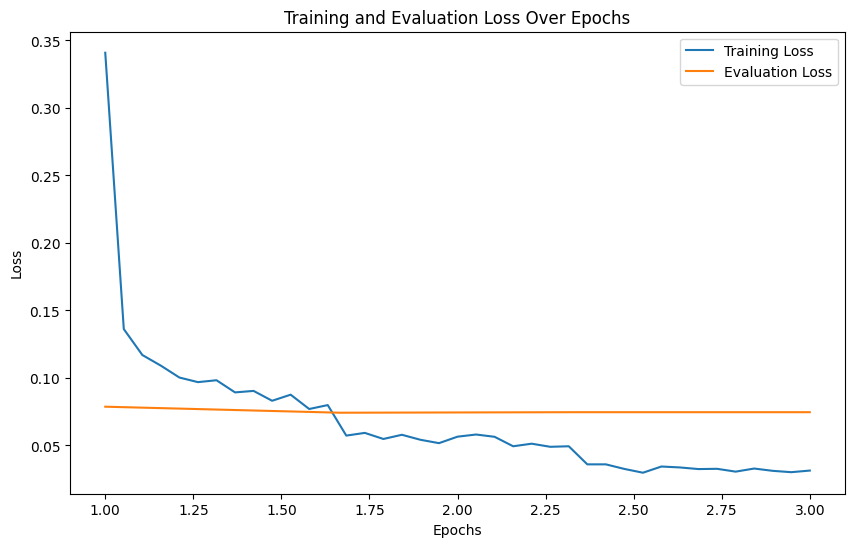

In [38]:
# Plot the training and evaluation loss
history = trainer.state.log_history

train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, (len(eval_loss)-1), num=len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.linspace(1, (len(eval_loss)-1), num=len(eval_loss)), eval_loss, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.show()

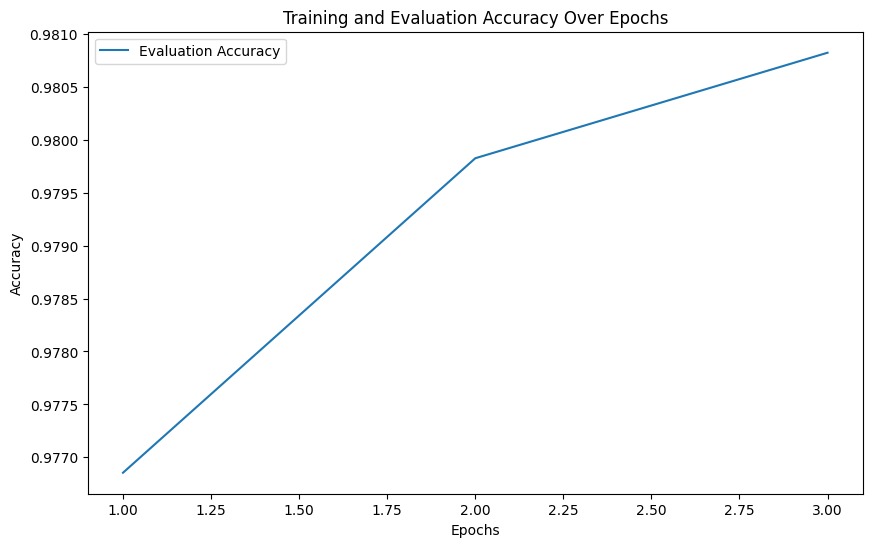

In [39]:
# Plot the evaluation Accuracy
history = trainer.state.log_history

eval_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, (len(eval_accuracy)-1), num=(len(eval_accuracy)-1)), eval_accuracy[:-1], label='Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Evaluation Accuracy Over Epochs')
plt.legend()
plt.show()

In [40]:
f = open("./history.txt", 'w', encoding='utf-8')

for item in history:
    f.write(f"{str(item)}\n")

f.close()

## Using the model

In [43]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification

In [44]:
# Load the model and tokenizer
output_dir = "./saved_model"
model = BertForTokenClassification.from_pretrained(output_dir)
tokenizer = BertTokenizerFast.from_pretrained(output_dir)

In [45]:
# Function to get the context explanation of a text
def get_context_explanation(text):
    # Tokenize the input text
    tokens = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    # Get the model's predictions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    # Get the predicted labels
    predictions = torch.argmax(outputs.logits, dim=2)
    
    # Convert token IDs to tokens
    tokens_list = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    labels = predictions.squeeze().tolist()

    # Load the label names
    label_names = model.config.id2label
    
    # Extract named entities and their context
    entities = []
    current_entity = {"type": None, "tokens": []}

    for token, label in zip(tokens_list, labels):
        if token in ('[CLS]', '[SEP]', '[PAD]'):
            continue
        
        label_name = label_names[label]
        
        if label_name.startswith("B-"):  # Beginning of a new entity
            if current_entity["tokens"]:
                entities.append(current_entity)
            current_entity = {"type": label_name[2:], "tokens": [token]}
        
        elif label_name.startswith("I-") and current_entity["type"] == label_name[2:]:
            current_entity["tokens"].append(token)
        
        else:
            if current_entity["tokens"]:
                entities.append(current_entity)
            current_entity = {"type": None, "tokens": []}
    
    if current_entity["tokens"]:
        entities.append(current_entity)

    # Generate the context explanation
    explanation = ["The text mentions several key entities."]
    for entity in entities:
        # Join tokens, handling subwords properly
        entity_tokens = [token.replace('##', '') if token.startswith('##') else token for token in entity["tokens"]]
        entity_text = tokenizer.convert_tokens_to_string(entity_tokens)
        entity_text = entity_text.replace(' - ', '-').strip()
        entity_type = entity['type']
        
        if entity_type == 'ORG':
            entity_type = 'organization'
        elif entity_type == 'GPE':
            entity_type = 'geopolitical entity'
        
        explanation.append(f"{entity_text} is a {entity_type}.")
    
    return " ".join(explanation)

In [46]:
# Example usage
text = '''Scientists are particularly interested in this region because it could offer clues about the early Solar System's evolution, as well as the geological processes that shaped the Moon.'''
context_explanation = get_context_explanation(text)
print(context_explanation)

The text mentions several key entities. the early Solar System ' s is a LOC. Moon is a LOC.
